# Milestone Project 2: SkimLit

## Confirm access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-739c7d2f-4be6-737b-f07f-643df26ff5c4)


## Get data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir ="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

In [ ]:
# Create function to read the lines of the document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filenames: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionary of abstract line data.

  Takes in filename, reads it contents and sort through each line,
  extracting things like target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):   # check to see if this is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract (starts from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions are fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 867 ms, sys: 103 ms, total: 971 ms
Wall time: 1.29 s


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

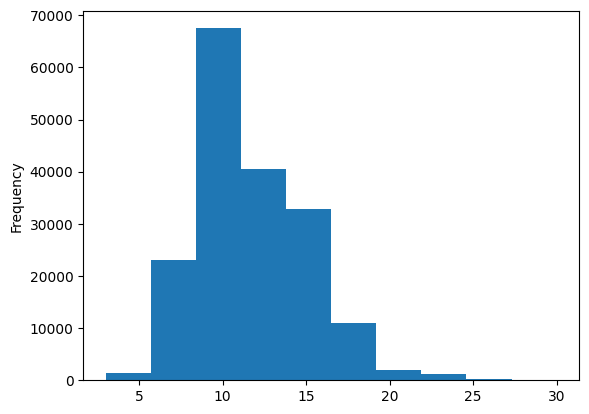

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))


train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipelinne
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper function script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-18 08:01:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-18 08:01:30 (65.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text) for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

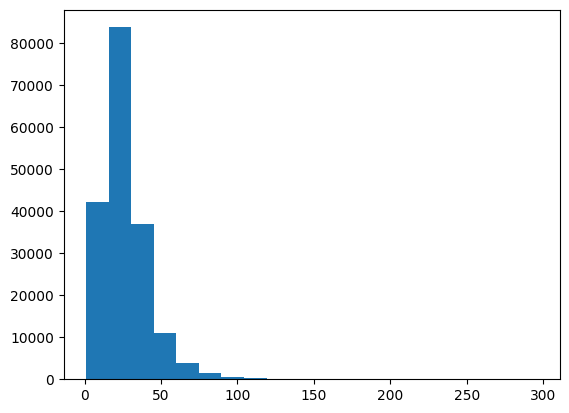

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

In [ ]:
# How many words are in our vocab?
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
fasting glucose , insulin , and homa of insulin resistance decreased significantly after the pd compared with the cd .

Length of text:20

Vectorized text: [[ 662  268  277    3 6936    4  277  504  212   39   21    2  868   34
     7    2  478    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding size result in drastically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name="token_embedding"
                               )

In [ ]:
# Show exampl embedding
print(f"Sentence before vecotrization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vecotrization:
 fasting glucose , insulin , and homa of insulin resistance decreased significantly after the pd compared with the cd .

Sentence after vectorization (before embedding):
 [[ 662  268  277    3 6936    4  277  504  212   39   21    2  868   34
     7    2  478    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.0029935  -0.00631287  0.04332492 ... -0.00118413 -0.04481551
   -0.04087404]
  [ 0.04237543  0.0299938   0.04197382 ... -0.03242232  0.02297815
   -0.01485859]
  [-0.00730064 -0.01559374  0.04500597 ... -0.02902646 -0.04112364
    0.01762443]
  ...
  [ 0.03671414 -0.02659751  0.03107895 ... -0.02689585 -0.02922393
   -0.00883541]
  [ 0.03671414 -0.02659751  0.03107895 ... -0.02689585 -0.02922393
   -0.00883541]
  [ 0.03671414 -0.02659751  0.03107895 ... -0.02689585 -0.029223

## Creating datasets (making sure our data loads as fast as possible)

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embeddings
x = layers.Conv1D(64, kernel_size=5, padding="same", activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) #condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



In [ ]:
model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
len(train_dataset)

5627

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only validate on 10% batches

Epoch 1/3
562/562 [==============================] - 43s 72ms/step - loss: 0.9317 - accuracy: 0.6303 - val_loss: 0.6924 - val_accuracy: 0.7397
Epoch 2/3
562/562 [==============================] - 15s 27ms/step - loss: 0.6576 - accuracy: 0.7573 - val_loss: 0.6285 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.6181 - accuracy: 0.7752 - val_loss: 0.5962 - val_accuracy: 0.7862


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5972 - accuracy: 0.7874


[0.5972229242324829, 0.7874354720115662]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 4s 4ms/step


(array([[4.61981684e-01, 1.41696945e-01, 9.43831876e-02, 2.77916372e-01,
         2.40218174e-02],
        [4.22866821e-01, 2.90745109e-01, 1.31168608e-02, 2.66194493e-01,
         7.07655866e-03],
        [1.32435203e-01, 1.21333823e-02, 1.04129803e-03, 8.54350269e-01,
         3.99081655e-05],
        ...,
        [4.25082271e-06, 7.01812445e-04, 4.53999382e-04, 2.02318938e-06,
         9.98837888e-01],
        [5.60120791e-02, 4.08917546e-01, 1.20824635e-01, 6.78924844e-02,
         3.46353292e-01],
        [1.75667152e-01, 6.64768577e-01, 3.76651697e-02, 3.84533405e-02,
         8.34457129e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74354561101549,
 'precision': 0.7838786514830576,
 'recall': 0.7874354561101549,
 'f1': 0.7849461942672699}

## Model 2: Feature extraction with pretrained token embeddings

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="USE")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentences:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding:{len(use_embedded_sentence[0])}")

Random sentences:
 early postoperative quality of life data captured differences in fatigue , indicating improved recovery after fp within a controlled trial .
Sentence after embedding:
[-0.03841191 -0.07773889 -0.0246671  -0.0172508   0.0112159  -0.00609447
  0.0038511   0.00832962  0.00446288  0.07582287  0.05244293  0.00904627
  0.04902315  0.01889451  0.02433334  0.0226675  -0.0314316   0.0729294
 -0.00594928  0.03309201 -0.05340233  0.03305076 -0.03930285  0.05589102
  0.04718134 -0.02771079 -0.07823844  0.07556594 -0.0328646  -0.04160918]

Length of sentence embedding:512


## Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model2_USE")

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit the model_2
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 20s 27ms/step - loss: 0.9131 - accuracy: 0.6499 - val_loss: 0.7960 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 14s 24ms/step - loss: 0.7688 - accuracy: 0.7008 - val_loss: 0.7539 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 13s 23ms/step - loss: 0.7519 - accuracy: 0.7130 - val_loss: 0.7373 - val_accuracy: 0.7161


In [ ]:
 # Evaluate on the whole validation dataset
 model_2.evaluate(valid_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.7413 - accuracy: 0.7136


[0.741272509098053, 0.7135906219482422]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 14s 13ms/step


array([[4.3625611e-01, 3.3336291e-01, 2.0003777e-03, 2.1859303e-01,
        9.7876433e-03],
       [3.3954310e-01, 4.9296477e-01, 4.1342662e-03, 1.5927806e-01,
        4.0797340e-03],
       [2.3222552e-01, 1.5043455e-01, 1.6384732e-02, 5.6124616e-01,
        3.9709017e-02],
       ...,
       [1.9081634e-03, 6.5448447e-03, 4.9926661e-02, 8.9488178e-04,
        9.4072545e-01],
       [3.1874641e-03, 4.6718709e-02, 2.0223624e-01, 1.1403637e-03,
        7.4671721e-01],
       [1.8555993e-01, 2.8765959e-01, 4.5120147e-01, 7.5130351e-03,
        6.8066031e-02]], dtype=float32)

In [ ]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calcuatle results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.35906262412286,
 'precision': 0.7142484989543108,
 'recall': 0.7135906262412286,
 'f1': 0.7108454029036974}

## Model 3: Conv1D with character embeddings

### Create a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'e a r l y   p o s t o p e r a t i v e   q u a l i t y   o f   l i f e   d a t a   c a p t u r e d   d i f f e r e n c e s   i n   f a t i g u e   ,   i n d i c a t i n g   i m p r o v e d   r e c o v e r y   a f t e r   f p   w i t h i n   a   c o n t r o l l e d   t r i a l   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Whats' the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

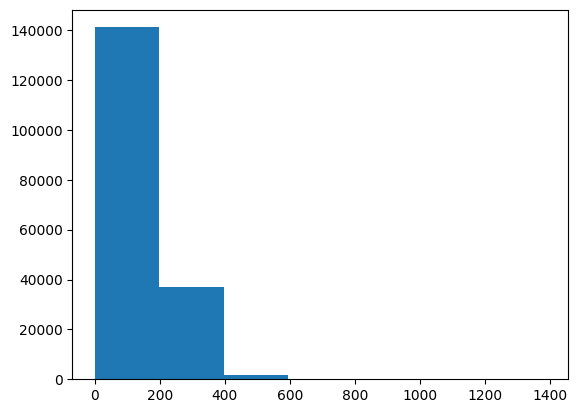

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [ ]:
# Find what character lenght covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits +string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token(OOV=out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
  # Adapt character vectorizer to training character
  char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocb stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters:{char_vocab[:5]}")
print(f"5 least common characters:{char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters:['', '[UNK]', 'e', 't', 'i']
5 least common characters:['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLenght of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars:{len(vectorized_chars[0])}")

Charified text:
 p a r t i c i p a n t s   a n d   c a r e g i v e r s   w e r e   n o t   b l i n d e d   a s   t o   t h e   a l l o c a t i o n   o f   i n t e r v e n t i o n s   ,   w h e r e a s   t h e   l a b o r a t o r y   d e t e r m i n i n g   h b a   (   @ c   )   r e m a i n e d   b l i n d e d   .

Lenght of random_train_chars: 126
\Vectorized chars:
[[14  5  8  3  4 11  4 14  5  6  3  9  5  6 10 11  5  8  2 18  4 21  2  8
   9 20  2  8  2  6  7  3 22 12  4  6 10  2 10  5  9  3  7  3 13  2  5 12
  12  7 11  5  3  4  7  6  7 17  4  6  3  2  8 21  2  6  3  4  7  6  9 20
  13  2  8  2  5  9  3 13  2 12  5 22  7  8  5  3  7  8 19 10  2  3  2  8
  15  4  6  4  6 18 13 22  5 11  8  2 15  5  4  6  2 10 22 12  4  6 10  2
  10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  

## Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # this is the size of the char embedding in the papaer
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n{char_embed_example}")
print(f"Charcater embedding shape: {char_embed_example.shape}")

Charified text:
 p a r t i c i p a n t s   a n d   c a r e g i v e r s   w e r e   n o t   b l i n d e d   a s   t o   t h e   a l l o c a t i o n   o f   i n t e r v e n t i o n s   ,   w h e r e a s   t h e   l a b o r a t o r y   d e t e r m i n i n g   h b a   (   @ c   )   r e m a i n e d   b l i n d e d   .

Embedded chars. (after vectorization and embedding):
[[[-0.00351691  0.02892632  0.03965801 ...  0.00882964  0.02752556
   -0.00057154]
  [ 0.01235607 -0.03461496  0.01040995 ... -0.02110147  0.02280984
   -0.03870612]
  [-0.02791199  0.04731888  0.00859916 ... -0.04984817 -0.00140516
   -0.015704  ]
  ...
  [-0.03859609 -0.01704279 -0.02949737 ... -0.02075888 -0.04205693
   -0.04676376]
  [-0.03859609 -0.01704279 -0.02949737 ... -0.02075888 -0.04205693
   -0.04676376]
  [-0.03859609 -0.01704279 -0.02949737 ... -0.02075888 -0.04205693
   -0.04676376]]]
Charcater embedding shape: (1, 290, 25)


In [ ]:
len(random_train_chars)

297

Building a Conv2D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 5

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2623 - accuracy: 0.4893 - val_loss: 1.0467 - val_accuracy: 0.5898
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0050 - accuracy: 0.5989 - val_loss: 0.9332 - val_accuracy: 0.6393
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.9164 - accuracy: 0.6417 - val_loss: 0.8498 - val_accuracy: 0.6735


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds= tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

945/945 [==============================] - 5s 5ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8722 - accuracy: 0.6625


[0.8721671104431152, 0.6625182032585144]

In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)

In [ ]:
model_3_results

{'accuracy': 66.25182046868794,
 'precision': 0.6563575306182282,
 'recall': 0.6625182046868794,
 'f1': 0.6547444082513395}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])
# 4. Create output layers - adding in Dropout, discussed in section 4.2
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978 

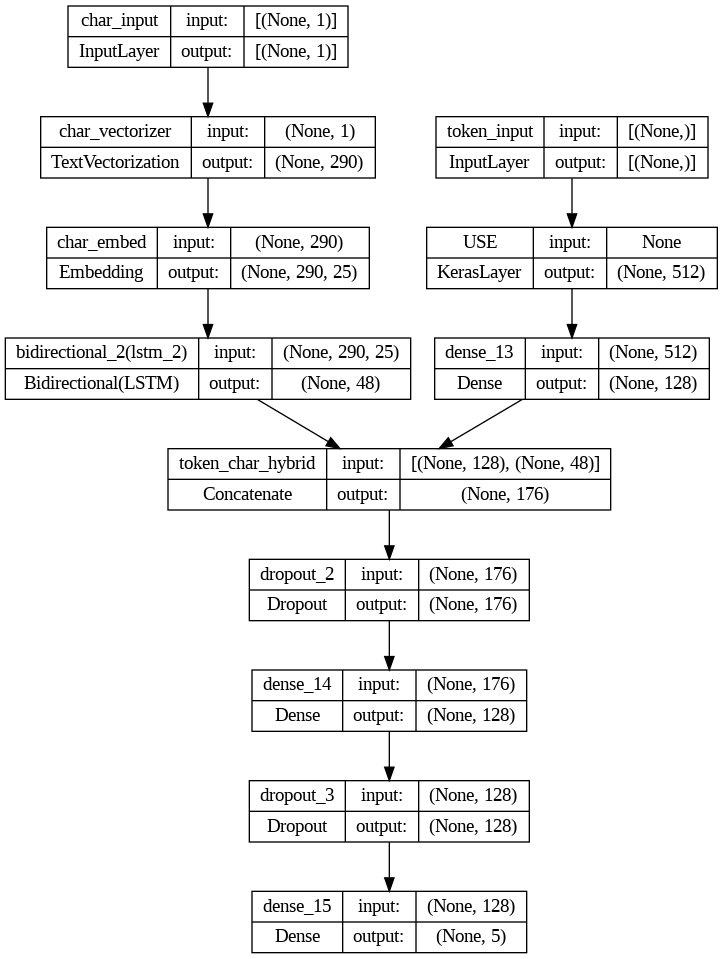

In [ ]:
# Plot hybrid token and character model
from keras. utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # Make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 47s 63ms/step - loss: 0.9769 - accuracy: 0.6117 - val_loss: 0.7759 - val_accuracy: 0.7025
Epoch 2/3
562/562 [==============================] - 57s 102ms/step - loss: 0.7992 - accuracy: 0.6923 - val_loss: 0.7154 - val_accuracy: 0.7374
Epoch 3/3
562/562 [==============================] - 30s 54ms/step - loss: 0.7724 - accuracy: 0.7082 - val_loss: 0.6978 - val_accuracy: 0.7430


In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 35s 33ms/step


array([[4.6944928e-01, 3.3927616e-01, 2.6718201e-03, 1.8276697e-01,
        5.8357054e-03],
       [3.8924286e-01, 3.6279073e-01, 2.3075021e-03, 2.4393949e-01,
        1.7193904e-03],
       [2.8294134e-01, 9.5953181e-02, 3.3859998e-02, 5.6408370e-01,
        2.3161815e-02],
       ...,
       [6.9522398e-04, 1.3080401e-02, 1.0030248e-01, 2.4722586e-04,
        8.8567466e-01],
       [9.6421167e-03, 5.7063546e-02, 2.4919063e-01, 4.5419107e-03,
        6.7956185e-01],
       [2.7248067e-01, 3.8102365e-01, 2.5828990e-01, 3.6009010e-02,
        5.2196778e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.31523897788958,
 'precision': 0.7330608767130845,
 'recall': 0.7331523897788959,
 'f1': 0.7320052934168846}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

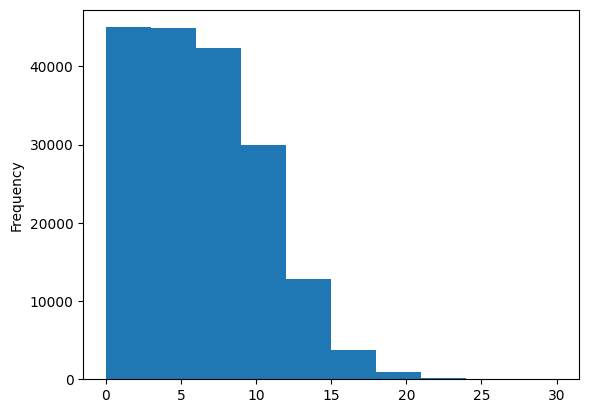

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

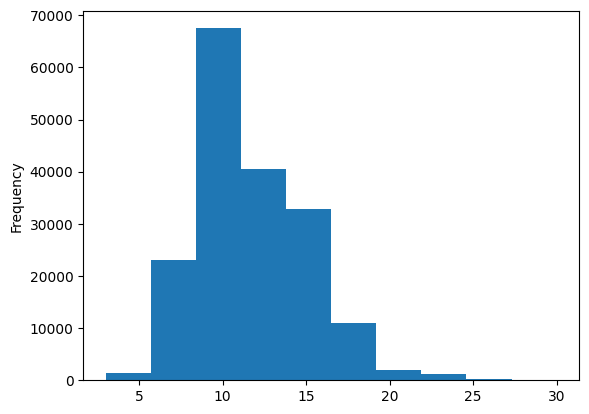

In [ ]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [ ]:
# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total line model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embedding into hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                total_line_model.output,
                                                                                z]
                                                                                )

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together mdoel with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_5_tribrid_embedding_model')

In [ ]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['input_9[0][0]']             
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   

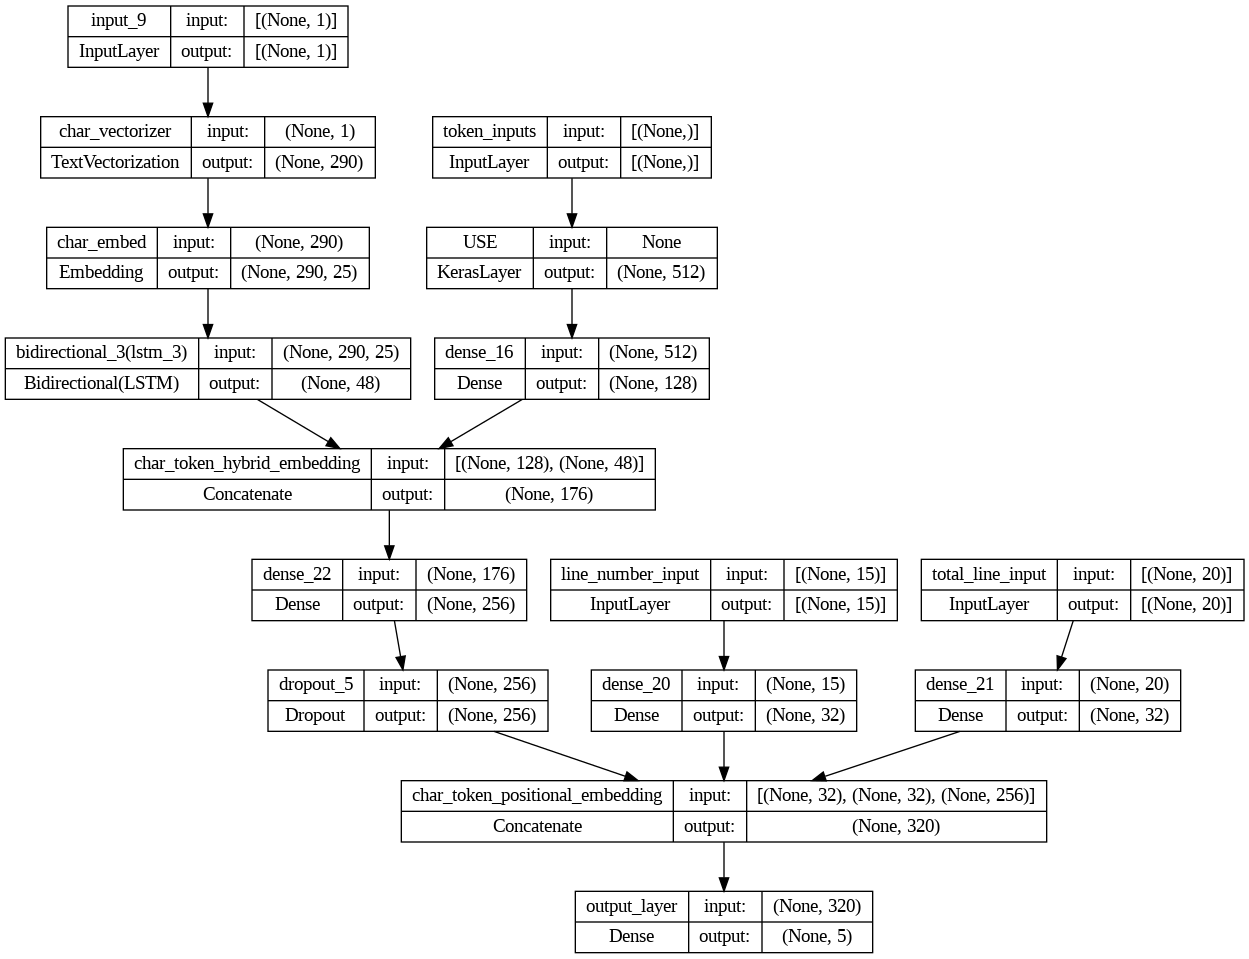

In [ ]:
# Plot model_5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Create tribrid embedding datasets using tf.data

In [ ]:
# Create training and validation datasets(with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Check input shape
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 67s 97ms/step - loss: 1.0928 - accuracy: 0.7260 - val_loss: 0.9800 - val_accuracy: 0.8082
Epoch 2/3
562/562 [==============================] - 52s 92ms/step - loss: 0.9682 - accuracy: 0.8154 - val_loss: 0.9484 - val_accuracy: 0.8271
Epoch 3/3
562/562 [==============================] - 39s 69ms/step - loss: 0.9503 - accuracy: 0.8263 - val_loss: 0.9363 - val_accuracy: 0.8321


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 30s 27ms/step


array([[0.5084625 , 0.11257391, 0.01220347, 0.35063866, 0.01612148],
       [0.5968412 , 0.08011544, 0.04323838, 0.2694409 , 0.01036406],
       [0.2920199 , 0.12300242, 0.12986629, 0.3907598 , 0.06435166],
       ...,
       [0.03554709, 0.10795271, 0.04823565, 0.02869791, 0.77956665],
       [0.02990456, 0.31483454, 0.07772402, 0.02323765, 0.55429924],
       [0.19300368, 0.6120446 , 0.09010959, 0.03911367, 0.06572847]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.46683437044882,
 'precision': 0.83365749360834,
 'recall': 0.8346683437044883,
 'f1': 0.8335733033610626}

In [ ]:
model_4_results

{'accuracy': 73.31523897788958,
 'precision': 0.7330608767130845,
 'recall': 0.7331523897788959,
 'f1': 0.7320052934168846}

## Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline":baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding":model_4_results,
                                  "model_5_pos_char_token_embedding":model_5_results})
all_model_results= all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.743546,0.783879,0.787435,0.784946
model_2_pretrained_token_embedding,71.359063,0.714248,0.713591,0.710845
model_3_custom_char_embedding,66.251820,0.656358,0.662518,0.654744
model_4_hybrid_char_token_embedding,73.315239,0.733061,0.733152,0.732005
model_5_pos_char_token_embedding,83.466834,0.833657,0.834668,0.833573


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

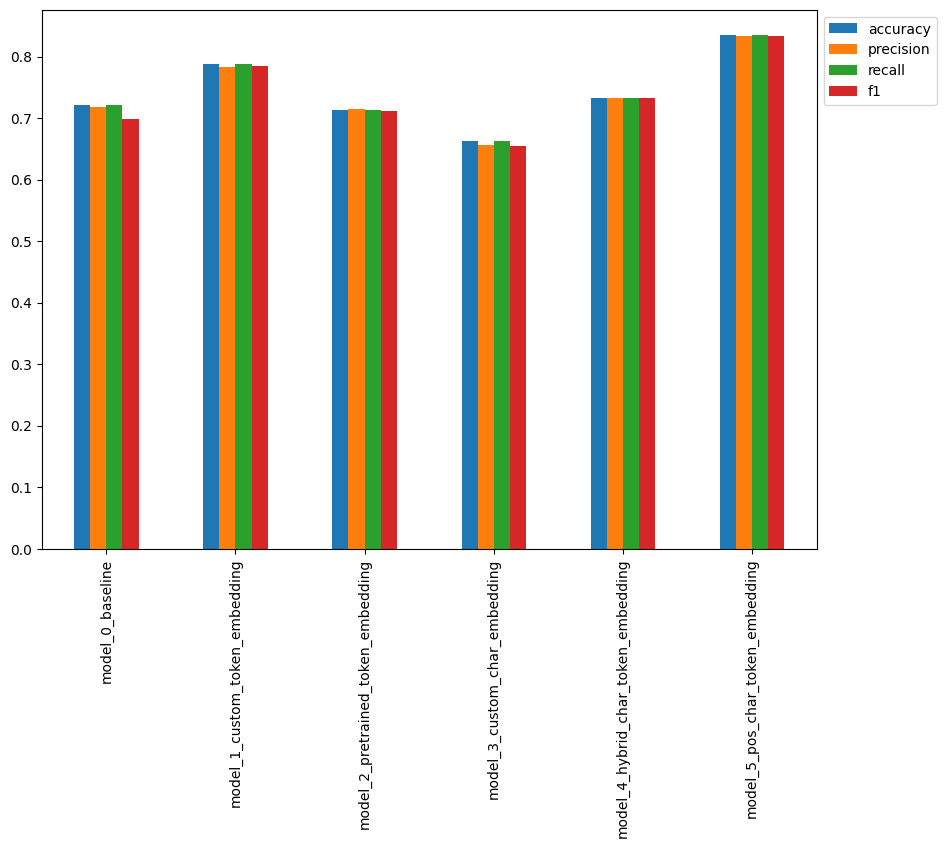

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

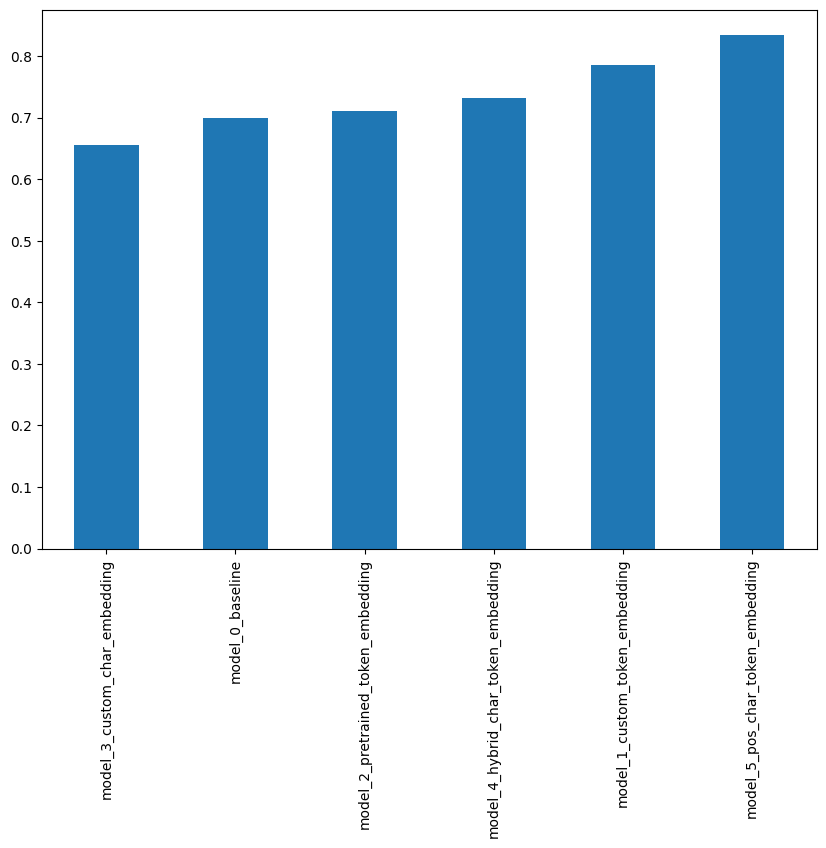

In [ ]:
# Sort the model results by f1-score
all_model_results.sort_values('f1', ascending=True)["f1"].plot(kind='bar',figsize=(10,7))

## Save and load model

In [ ]:
# Save the best performing model to SavedModel format
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 33s 35ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)

In [ ]:
loaded_model_results

{'accuracy': 83.46683437044882,
 'precision': 0.83365749360834,
 'recall': 0.8346683437044883,
 'f1': 0.8335733033610626}

In [ ]:
model_5_results

{'accuracy': 83.46683437044882,
 'precision': 0.83365749360834,
 'recall': 0.8346683437044883,
 'f1': 0.8335733033610626}

In [ ]:
assert model_5_results == loaded_model_results

In [ ]:
model_5_results == loaded_model_results

True

## Download and load in a pretrained model from Google Storage

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-05-18 09:18:03--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.171.207, 74.125.126.207, 173.194.206.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.171.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  18.0MB/s    in 24s     

2024-05-18 09:18:27 (38.4 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model

In [ ]:
# Load in download Google Storage model
loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")

In [ ]:
# Evaluate the loaded Google Storage model
loaded_gs_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 26s 27ms/step - loss: 0.9388 - accuracy: 0.8303


[0.9387755990028381, 0.830332338809967]